# Piecewise cylindrical CWS optimization

A notebook to run a shape + current optimization for a given plasma configuration

- Define the cost
- Set up the coil factory
- Set up the optimizer
- Run the optimization

In [1]:
%gui qt

from mayavi import mlab

from stellacode.costs import EMCost
from stellacode.surface import IntegrationParams
from stellacode.costs import (
    AggregateCost,
    DistanceCost,
    PoloidalCurrentCost,
    CurrentCtrCost,
)
from stellacode.costs.utils import Constraint

from stellacode.surface import WrappedCoil,FourierSurfaceFactory
from stellacode.optimizer import Optimizer
from stellacode.tools.plots import plot_CWS_LCFS, plot_cross_sections


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Load the W7-X plasma configuration

In [2]:
from stellacode.definitions import w7x_plasma
plasma_config = w7x_plasma

In [3]:
n_harmonics_phi = 16
n_harmonics_u = 4
n_harmonics_v = 4
factor = 4
rotate_diff_current = 3  # num_cyl
make_joints=False # oblique cut to make joints btw cylinders

lamb = 1e-27
train_currents = True
currentit = 1e8

maxiter = 20
optim_method = "L-BFGS-B"

In [4]:
integration_par = IntegrationParams(num_points_u=n_harmonics_u * factor, num_points_v=n_harmonics_v * factor)
Sp = FourierSurfaceFactory.from_file(plasma_config.path_plasma, integration_par=integration_par)

In [5]:
costs = []

Constraint related to the magnetic field regression

In [6]:
em_cost = EMCost.from_plasma_config(
    lamb=1e-30,
    plasma_config=plasma_config,
    integration_par=integration_par,
    train_currents=True
)
costs.append(em_cost)

Constraint on the distance between LCFS and coil

In [7]:
distance = DistanceCost(
    Sp=em_cost.Sp,
    constraint=Constraint(
        limit=em_cost.Sp.get_minor_radius(), 
        distance=0.03, 
        minimum=True, 
        method="quadratic"
    ),
)
costs.append(distance)

Add a limit on the current intensity

In [8]:
current_ctr = CurrentCtrCost(
    constraint=Constraint(
        limit=currentit, 
        distance=0.3*currentit, 
        minimum=False, 
        method="quadratic"
        )
    )
costs.append(current_ctr)

Add a constraint to avoid negative poloidal currents

In [9]:
pol_curr_ctr = PoloidalCurrentCost(
    Sp=em_cost.Sp, constraint=Constraint(limit=0, distance=1e6, minimum=True, method="quadratic")
)
costs.append(pol_curr_ctr)

Sum of all these costs

In [10]:
agg_cost = AggregateCost(
    costs=costs
)

Definition of the coil factory.

In [11]:
coil_factory = WrappedCoil.from_plasma(
    surf_plasma=em_cost.Sp,
    surf_type="cylindrical",
    make_joints=make_joints,
    n_harmonics=n_harmonics_phi, # Number of harmonics in the current fourier expansion
    factor=factor, # The number of points on the grid is n_harmonics * factor
)

Parameters that will be optimized :

In [12]:
coil_factory.get_trainable_params()

{'0.fourier_coeffs': Array([[0., 0.]], dtype=float32),
 '0.axis_angle': 0.0,
 '0.radius': Array(0.9530674, dtype=float32),
 '0.distance': 5.5,
 '1.0.phi_mn': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

Definition of the optimizer

In [13]:
opt = Optimizer.from_cost(
    agg_cost,
    coil_factory,
    method=optim_method, # Quasi-Newton method very good for non constrained optimization
    kwargs=dict(
        options={"disp": True, "maxiter": maxiter},
    ),
    save_res=True,
    output_folder_name="../outputs/"
)

Parameters before optimization:

In [14]:
opt.init_param

{'0.fourier_coeffs': Array([[0., 0.]], dtype=float32),
 '0.axis_angle': 0.0,
 '0.radius': Array(0.9530674, dtype=float32),
 '0.distance': 5.5,
 '1.0.phi_mn': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

Run the optimization

In [15]:
cost, metrics, results, optimized_params = opt.optimize()
print(metrics)

max_deltaB_normal: 8.355348587036133, deltaB_B_rmse: 18165.7109375, deltaB_B_max: 16774.83203125, cost_B: 64.07511901855469, em_cost: 64.07511901855469, max_j: 2684352.25, min_distance: 0.014405808411538601, mean_min_distance: 5.085792064666748, max_distance: 12.67776107788086, mean_max_distance: 9.358405113220215, cost_distance: 108.45288848876953, cost_j_ctr: 0.0, cost_ju_ctr: 542769.375, max_ju: -5188746.5, min_ju: -5188746.5, total_cost: 542941.875, 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          215     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.42942D+05    |proj g|=  1.06492D+07
max_deltaB_normal: 555606.5625, deltaB_B_rmse: 657.7156372070312, deltaB_B_max: 389.57452392578125, cost_B: 1778606.25, em_cost: 1778606.25, max_j: 957156288.0, min_distance: 0.014362011104822159, mean_min_distance: 5.085799694061279, max_distance: 12.67786979675293, mean_max_distance: 9.358344078063965, cost_distance: 108.3952865600586, cost_j_ctr: 0.0, cost_ju_ctr: 9054309376.0, max_ju: 1850103936.0, min_ju: -1582628224.0, total_cost: 9056088064.0, 
max_deltaB_normal: 11.4376802444458, deltaB_B_rmse: 802.7820434570312, deltaB_B_max: 554.5182495117188, cost_B: 65.12593078613281, em_cost: 65.12593078613281, max_j: 3243972.75, min_distance: 0.014405524358153343, mean_min_distance: 5.085792064666748, max_distance: 12.67776107788086, mean_max_distance: 9.358405113


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


max_deltaB_normal: 8.018566131591797, deltaB_B_rmse: 2329.3017578125, deltaB_B_max: 1387.896240234375, cost_B: 62.73516845703125, em_cost: 62.73516845703125, max_j: 3267063.25, min_distance: 0.01440099161118269, mean_min_distance: 5.085792064666748, max_distance: 12.67776107788086, mean_max_distance: 9.358403205871582, cost_distance: 108.45233154296875, cost_j_ctr: 0.0, cost_ju_ctr: 539262.125, max_ju: -4344247.5, min_ju: -6315102.0, total_cost: 539433.3125, 

At iterate   11    f=  5.39433D+05    |proj g|=  9.45223D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  215     11     28      1     0     0   9.452D+03   5

Optimized parameters :

In [16]:
coil_factory.get_trainable_params()

{'0.fourier_coeffs': array([[-9.84778309e-08, -3.52433446e-07]]),
 '0.axis_angle': array(-6.55444391e-06),
 '0.radius': array(0.95306801),
 '0.distance': array(5.49999911),
 '1.0.phi_mn': array([ 1.09836347e-03, -1.06065298e-04,  3.68122278e-04, -5.37983884e-05,
         2.22495061e-04, -3.64153085e-05,  7.89614755e-07, -4.58097363e-07,
        -1.34462876e-07,  4.52025137e-08,  8.09743402e-08,  2.41168231e-08,
         9.74916069e-07,  2.87065547e-07,  1.66247260e-07, -3.87813933e-08,
        -2.89282179e-08, -5.91387858e-08, -7.44293483e-07,  1.52660380e-07,
         5.46384218e-08, -5.62884262e-08, -6.16921789e-08,  2.27899035e-09,
        -9.78044405e-07, -2.14774262e-07, -1.67715303e-07,  1.02435859e-07,
         8.80163595e-08,  1.14148142e-07,  1.36110491e-06, -4.09847087e-08,
         3.71615449e-08, -2.96026413e-08, -2.37252344e-08, -1.30543548e-07,
        -2.80987845e-07,  9.12298895e-08,  8.24812875e-08, -3.19343805e-08,
        -5.38825432e-08, -5.62053211e-09, -1.12462624

We can now plot the results

/!\ the parameters of the coil factory were changed in place during the optimization

In [22]:
coil_surface = coil_factory().get_coil(results.phi_mn_wnet_cur)

if make_joints:
    cut_tor = None
else:
    cut_tor = n_harmonics_phi * factor // rotate_diff_current

coil_surface.plot(
    vector_field=coil_surface.j_3d,
    reduce_res=1,
    quiver_kwargs=dict(
        line_width=2,
        scale_factor=0.08,
    ),
    cut_tor=cut_tor,
)

<PolarAxes: >

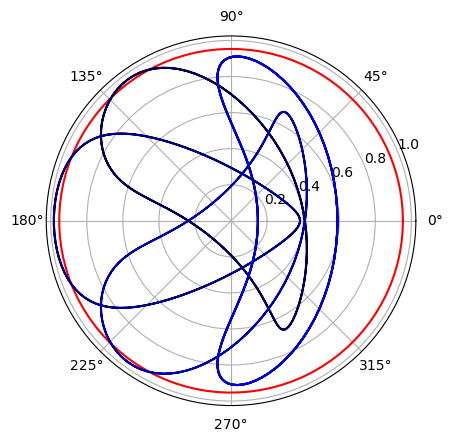

In [18]:
plot_cross_sections(coil_factory, Sp)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'CWS and LCFS'}, xlabel='X', ylabel='Y'>)

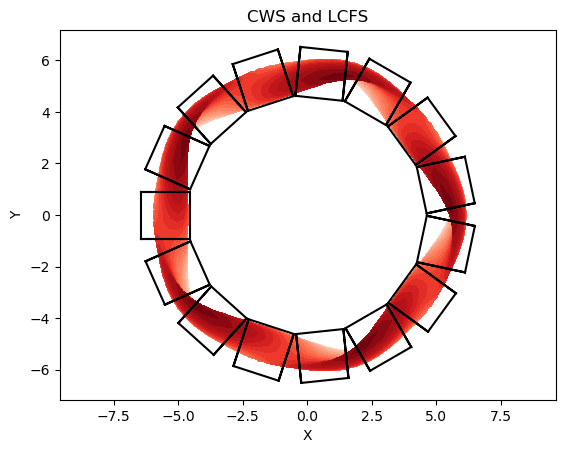

In [19]:
plot_CWS_LCFS(coil_surface, em_cost.Sp, n_cyl = rotate_diff_current)